# Watershed
Segmentación basada en el algoritmo de watershed o "cuenca hidrográfica"

In [2]:
import numpy as np
import cv2 as cv
import supervision as sv

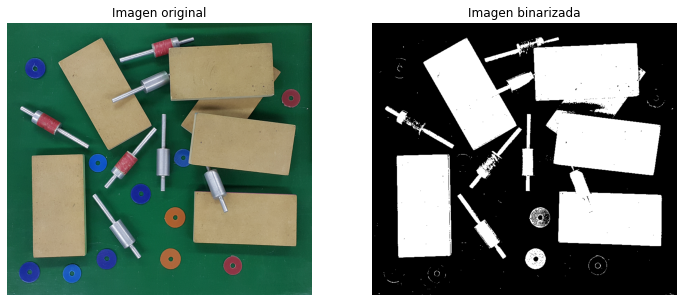

In [3]:
# Cargamos la imagen y la binarizamos por el método de Otsu
img = cv.imread('piezas.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Binarizamos...
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

sv.plot_images_grid(
    images=[img, thresh],
    titles=["Imagen original", "Imagen binarizada"],
    grid_size=(1, 2),)

### Marcadores

El método de watershed por OpenCV precisa que se le indiquen los marcadores (semillas) de manera que no se genere sobresegmentacion.

Esto se logra a través de operaciones morfológicas

#### Operaciones morfológicas

Se busca intentar separar fondo de objetos lo mejor posible. Quedará:

- Una zona de fondo seguro
- Una zona de objetos seguro
- Una zona de incertezas (la resta de las dos anteriores)

### Pre-procesamos mediante operaciones morfologicas

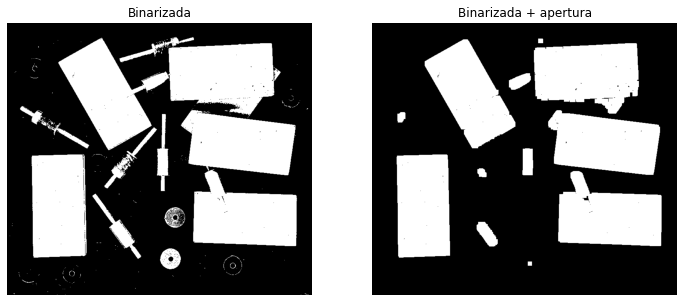

In [19]:
# Creamos un elemento estructurante y aplicamos operaciones morfologicas
kernel = np.ones((3,3), np.uint8)

# Aplicamos una serie de iteraciones de apertura
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations = 5)

sv.plot_images_grid(
    images=[thresh, opening],
    titles=["Binarizada", "Binarizada + apertura"],
    grid_size=(1, 2),)

### Buscamos las zonas de objeto (sure foreground) y fondo (sure background)

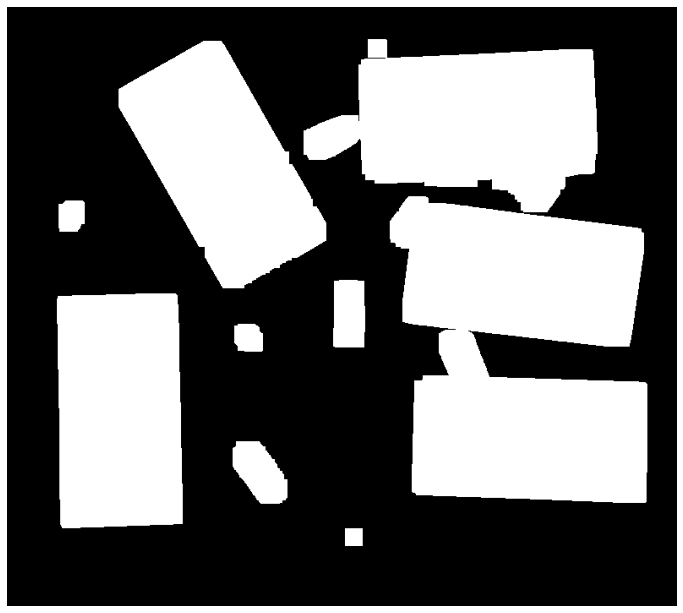

In [20]:
# Área de fondo (background) segura. (Zona negra)
sure_bg = cv.dilate(opening, kernel, iterations=5)
sv.plot_image(sure_bg)

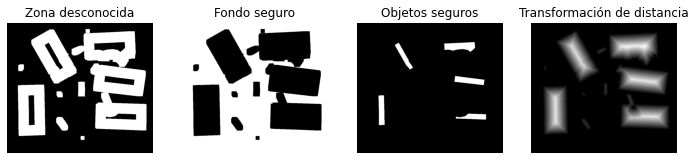

In [23]:
# Búsqueda del área de objeto (foreground) segura.
# Transformación de distancia (distancia de cada píxel al cero más cercano)
#------------------------------------------------------------------------------------
# Conviene cerrar primero la figura para que no haya agujeros (ceros) dentro de los objetos que afecten la transformada
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations = 2)
# Ahora sí aplicamos la transformación de distancia
dist_transform = cv.distanceTransform(closing, cv.DIST_L2, maskSize=5)
# Área de objeto (sure foreground) segura. Zona blanca!
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
# Búsqueda de la región no definida
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

#Graficamos...
#=============
sv.plot_images_grid(
    images=[unknown, cv.bitwise_not(sure_bg), sure_fg, dist_transform],
    titles=[
        "Zona desconocida", 
        "Fondo seguro", 
        "Objetos seguros", 
        "Transformación de distancia"],
    grid_size=(1, 4),)

#### Etiquetado

En función del análisis morfológico anterior es que se realiza el etiquetado (utilizando componentes conexos)

- Cada supuesto objeto con una etiqueta diferente
- Los pixeles con incertidumbre con etiqueta 0

(709, 793)


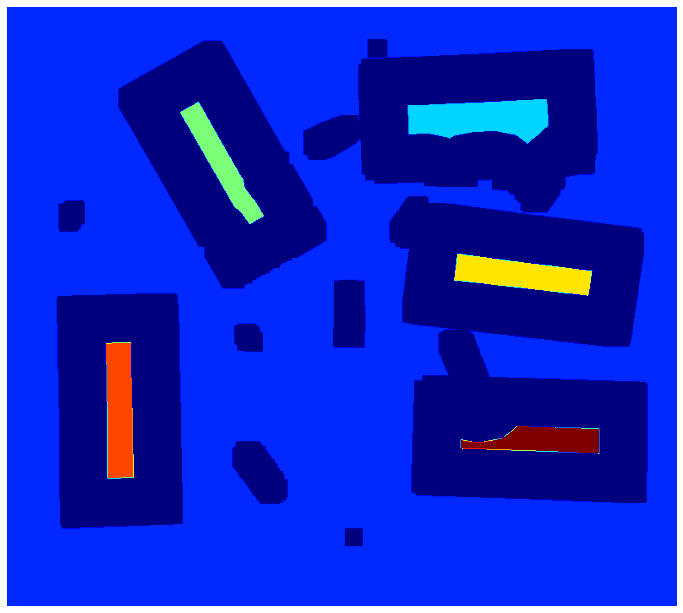

In [24]:
# Etiquetado de marcadores (similar a flood fill)
ret, connected_coord = cv.connectedComponents(sure_fg)
# Agregar un uno ('1') a todas las etiquetas (para evitar la etiqueta '0')
# CC asigna 0 para el background pero watershed necesita que el 0 este asociado a 
# la region desconocida o indefinida
connected_coord = connected_coord + 1
# Ahora, marcamos la región de incertezas con cero
connected_coord[unknown==255] = 0

print(connected_coord.shape)
sv.plot_image(connected_coord, cmap='jet')

### Watershed

Una vez definidos los marcadores se corre el algoritmo de watersheed.

Los bordes (devueltos por el algoritmo con valor -1) los "pintamos" de color rojo

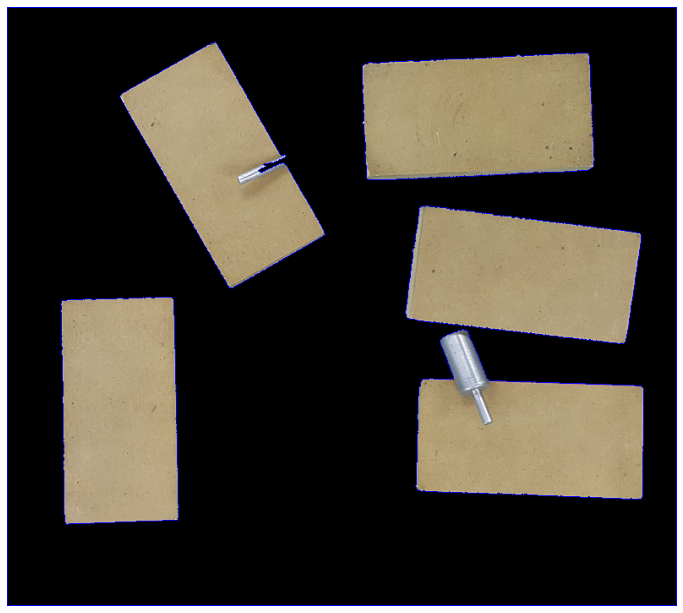

In [ ]:
img_out = img.copy()
# la salida de watershed es una matriz con -1 en las posiciones de bordes y 1 en los pixeles de background
markers = cv.watershed(img_out, connected_coord)
img_out[markers == -1] = [0,0,255]
img_out[markers == 1] = [0,0,0]

sv.plot_image(img_out, cmap='jet')